# Day 16 — Feature Engineering & Selection

**Goal:** Transform raw data into meaningful features and select the most informative subset to improve model performance and interpretability.

This notebook uses the `breast_cancer` dataset from `scikit-learn` as a working example. Sections include EDA, preprocessing, PCA, three flavors of feature selection, model comparison, and visualizations.



In [1]:
# Imports and dataset loading
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = load_breast_cancer(as_frame=True)
X = data.frame.drop(columns=['target'])
y = data.frame['target']

print('Feature shape:', X.shape)
X.head()

Feature shape: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Exploratory Data Analysis (EDA)
- Quick look at distributions, correlations, and class balance.


target
1    0.627417
0    0.372583
Name: proportion, dtype: float64

Feature summary:


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


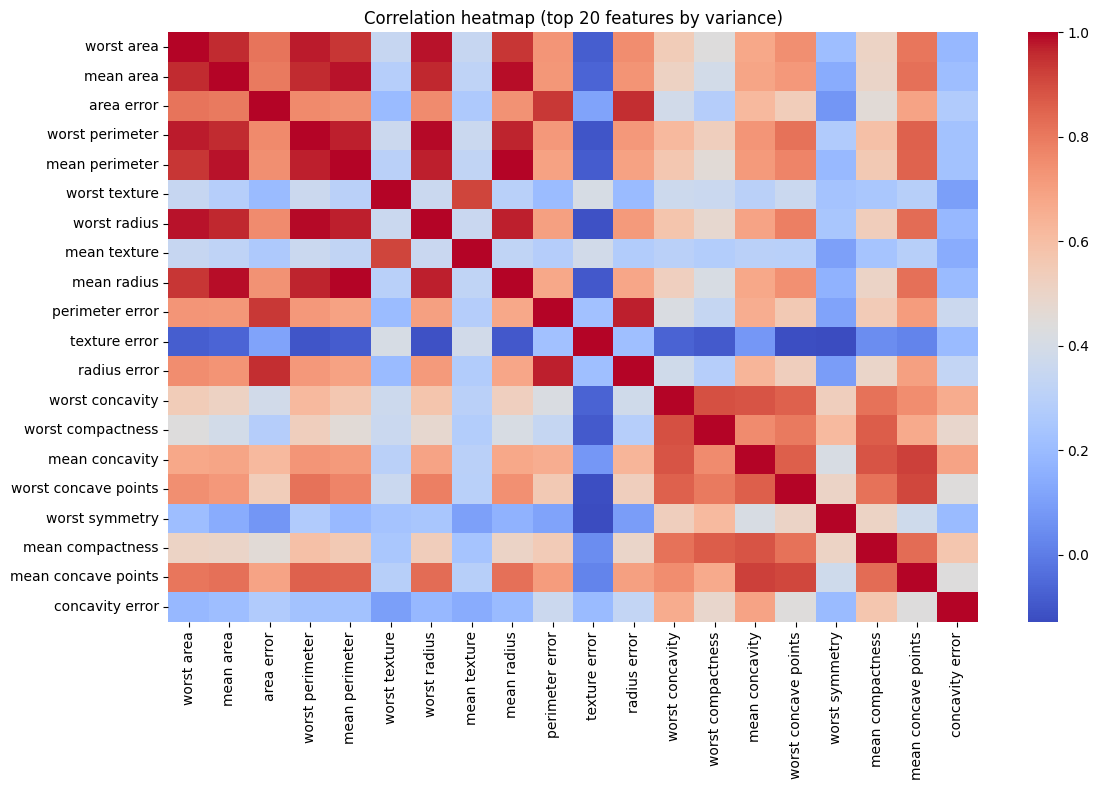

In [2]:
# Class balance
print(y.value_counts(normalize=True))
print('\nFeature summary:')
display(X.describe().T)

# Correlation heatmap (top 20 features by variance to keep visualization readable)
variances = X.var().sort_values(ascending=False)
top_feats = variances.index[:20].tolist()
plt.figure(figsize=(12,8))
sns.heatmap(X[top_feats].corr(), annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Correlation heatmap (top 20 features by variance)')
plt.tight_layout()
plt.show()

## Preprocessing
- Scale numerical features using `StandardScaler`.
- Splitting data for evaluation using stratified folds.


In [3]:
# Baseline preprocessing & model evaluation
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Baseline model: Logistic Regression and Random Forest with cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg = LogisticRegression(max_iter=2000, solver='lbfgs')
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

def cv_scores(model, X_, y_, cv=skf):
    scores = cross_val_score(model, X_, y_, cv=cv, scoring='roc_auc', n_jobs=-1)
    return scores.mean(), scores.std()

print('Baseline (all features) ROC-AUC:')
for name, model in [('LogisticRegression', logreg), ('RandomForest', rf)]:
    mean, std = cv_scores(model, X_scaled, y)
    print(f'{name}: {mean:.4f} ± {std:.4f}')

Baseline (all features) ROC-AUC:
LogisticRegression: 0.9953 ± 0.0055
RandomForest: 0.9895 ± 0.0077


## Dimensionality Reduction with PCA
- Use PCA to inspect explained variance and consider lower-dimensional representations.

Original feature count: 30
PCA components to retain 95% variance: 10


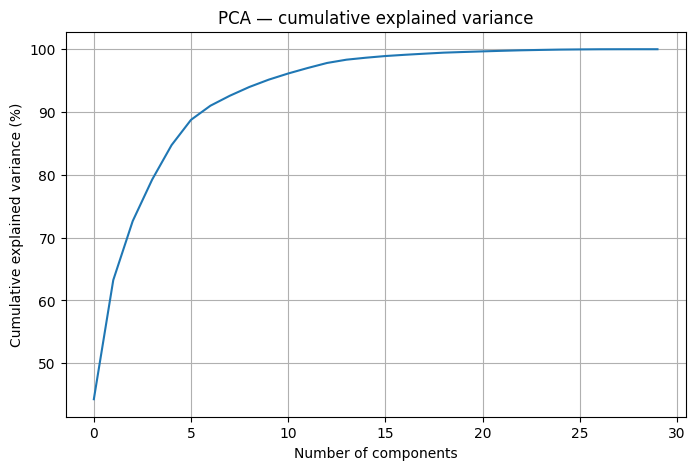

In [4]:
# PCA for explained variance
pca = PCA(n_components=0.95, random_state=42)  # preserve 95% variance
X_pca = pca.fit_transform(X_scaled)
print('Original feature count:', X.shape[1])
print('PCA components to retain 95% variance:', X_pca.shape[1])

# Scree plot / explained variance
pca_full = PCA().fit(X_scaled)
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_)*100)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance (%)')
plt.title('PCA — cumulative explained variance')
plt.grid(True)
plt.show()

## Feature Selection Approaches
We demonstrate three common approaches:

1. **Filter method** — `SelectKBest` (chi-squared) for univariate selection.
2. **Wrapper method** — `RFE` with Logistic Regression.
3. **Embedded method** — feature importance from Random Forest.

We will compare model performance after selecting features with each method.

In [5]:
# 1) Filter: SelectKBest (chi2)
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_mm = pd.DataFrame(mms.fit_transform(X), columns=X.columns)  # scale to [0,1] required for chi2

k = 10
skb = SelectKBest(score_func=chi2, k=k)
skb.fit(X_mm, y)
selected_filter = X.columns[skb.get_support()].tolist()
print('Filter-selected features (SelectKBest - chi2):', selected_filter)

Filter-selected features (SelectKBest - chi2): ['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']


In [6]:
# 2) Wrapper: RFE with Logistic Regression
rfe_est = LogisticRegression(max_iter=2000, solver='lbfgs')
rfe = RFE(estimator=rfe_est, n_features_to_select=10, step=1)
rfe.fit(X_scaled, y)
selected_rfe = X.columns[rfe.get_support()].tolist()
print('Wrapper-selected features (RFE):', selected_rfe)

Wrapper-selected features (RFE): ['mean concave points', 'radius error', 'area error', 'compactness error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']


Embedded-selected features (RandomForest top 10): ['worst perimeter', 'worst area', 'worst concave points', 'mean concave points', 'worst radius', 'mean concavity', 'mean area', 'mean perimeter', 'mean radius', 'area error']


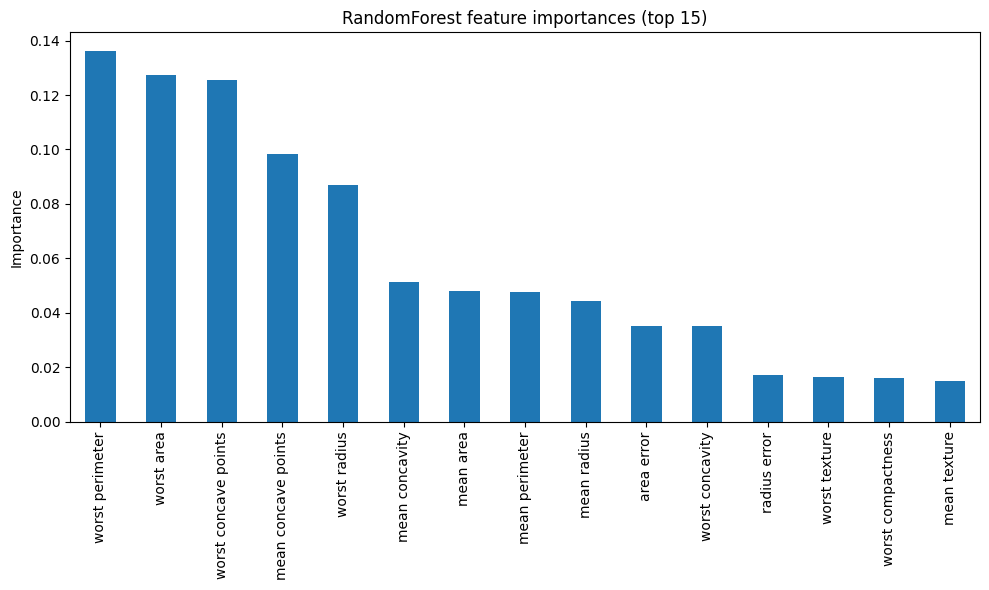

In [7]:
# 3) Embedded: RandomForest feature importance
rf_fit = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rf_fit.fit(X_scaled, y)
importances = pd.Series(rf_fit.feature_importances_, index=X.columns).sort_values(ascending=False)
selected_embedded = importances.head(10).index.tolist()
print('Embedded-selected features (RandomForest top 10):', selected_embedded)

# Plot feature importances (top 15)
plt.figure(figsize=(10,6))
importances.head(15).plot(kind='bar')
plt.title('RandomForest feature importances (top 15)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

## Model Performance Comparison
Evaluate Logistic Regression and Random Forest using:
- All features
- Features selected by SelectKBest
- Features selected by RFE
- Features selected by RandomForest importance

Compare using ROC-AUC with 5-fold stratified CV.

In [8]:
# Helper to evaluate models on selected feature sets
def evaluate_feature_set(feature_list, X_df=X_scaled, y_ser=y, cv=skf):
    X_sub = X_df[feature_list]
    results = {}
    for name, model in [('LogisticRegression', LogisticRegression(max_iter=2000, solver='lbfgs')),
                        ('RandomForest', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))]:
        mean, std = cv_scores(model, X_sub, y_ser, cv=cv)
        results[name] = (mean, std)
    return results

feature_sets = {
    'All': X_scaled.columns.tolist(),
    'SelectKBest_chi2': selected_filter,
    'RFE_LogReg': selected_rfe,
    'RF_importance_top10': selected_embedded
}

comparison = {}
for set_name, feats in feature_sets.items():
    comparison[set_name] = evaluate_feature_set(feats)

import pandas as pd
comp_df = pd.DataFrame({(m, set_name): comparison[set_name][m] for set_name in comparison.keys() for m in comparison[set_name].keys()}).T
comp_df.columns = ['ROC_AUC_mean', 'ROC_AUC_std']
comp_df

,,ROC_AUC_mean,ROC_AUC_std
LogisticRegression,All,0.995314,0.005471
RandomForest,All,0.989545,0.007720
LogisticRegression,SelectKBest_chi2,0.989322,0.008667
RandomForest,SelectKBest_chi2,0.984752,0.010380
LogisticRegression,RFE_LogReg,0.996771,0.002949
RandomForest,RFE_LogReg,0.990804,0.007792
LogisticRegression,RF_importance_top10,0.991620,0.006130
RandomForest,RF_importance_top10,0.984520,0.009567


### Results — ROC-AUC comparison (mean ± std)
Interpret differences and consider trade-offs between fewer features and marginal performance change.

In [9]:
# Present results
display(comp_df.style.format({'ROC_AUC_mean':'{:.4f}','ROC_AUC_std':'{:.4f}'}))

,,ROC_AUC_mean,ROC_AUC_std
LogisticRegression,All,0.9953,0.0055
RandomForest,All,0.9895,0.0077
LogisticRegression,SelectKBest_chi2,0.9893,0.0087
RandomForest,SelectKBest_chi2,0.9848,0.0104
LogisticRegression,RFE_LogReg,0.9968,0.0029
RandomForest,RFE_LogReg,0.9908,0.0078
LogisticRegression,RF_importance_top10,0.9916,0.0061
RandomForest,RF_importance_top10,0.9845,0.0096


## Key Takeaways
- Feature engineering and selection often yield more performance gains than switching models.
- Filter methods are fast but ignore feature interactions.
- Wrapper methods (RFE) consider model behavior but are computationally heavier.
- Embedded methods balance performance and cost; tree-based importances are practical.


